In [27]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import plot_tree

## Loading our data. 



In [55]:

data = pd.read_csv("heartfailure.csv")
data.shape
# data.head()

(299, 13)

#### Seeing if there's any empty entries.

In [12]:
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

<font size=4>Quite a discepancy in female and male ratio of smokers</font>

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X = data.drop(['DEATH_EVENT'],axis=1)
Y=data['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(
                X, Y, stratify=data['DEATH_EVENT'], random_state=0)
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred= tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy
print(f'Accuracy: {accuracy}')
print(f'Error Rate: {error_rate}')


Accuracy: 0.84
Error Rate: 0.16000000000000003


              precision    recall  f1-score   support

           0       0.87      0.80      0.84        51
           1       0.64      0.75      0.69        24

    accuracy                           0.79        75
   macro avg       0.76      0.78      0.76        75
weighted avg       0.80      0.79      0.79        75



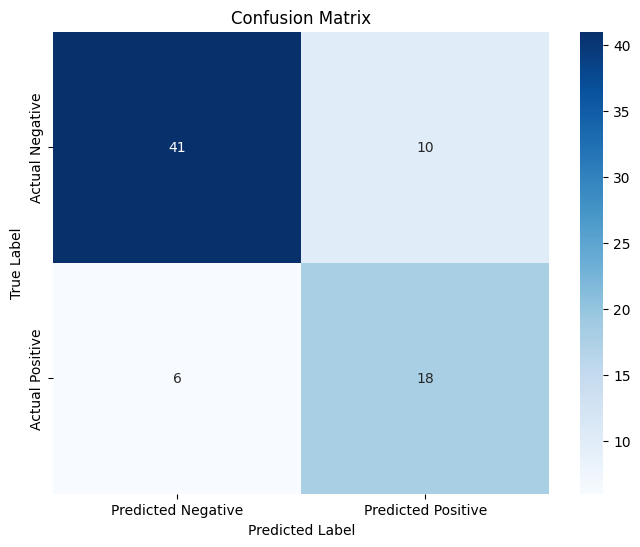

In [26]:
print(classification_report(y_test, y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

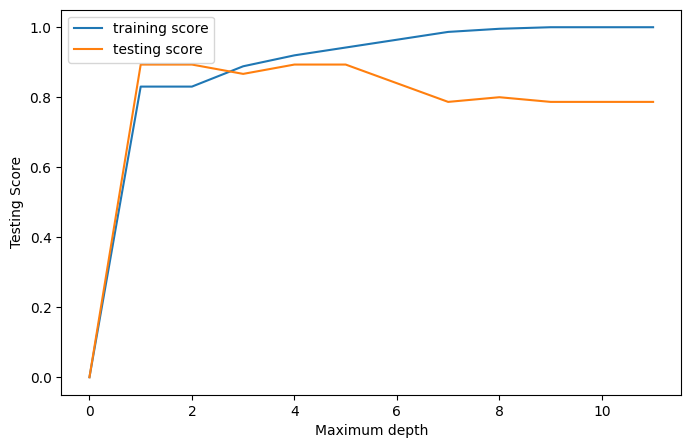

In [15]:
#Plotting the scores with diferrent max depth

n = 12
training_score = np.zeros(n)
testing_score = np.zeros(n)
diff_score = np.zeros(n)
for i in range(1,n):
    tree = DecisionTreeClassifier(max_depth=i,random_state=0)
    tree.fit(X_train, y_train)
    training_score[i]= tree.score(X_train, y_train)
    testing_score[i] = tree.score(X_test, y_test)
    diff_score[i] = np.abs(training_score[i]-testing_score[i])
    
    
plt.figure(figsize=(8,5))    
sns.lineplot(x=range(n),y=training_score,label="training score")
sns.lineplot(x=range(n),y=testing_score,label="testing score")
plt.ylabel("Testing Score")
plt.xlabel("Maximum depth")
plt.legend()

In [16]:
tree = DecisionTreeClassifier(max_depth=4,random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

At maxdepth of 4, the difference between training score and testing score is the least. And subsequently they diverge.

### Without setting any hyper-parameters

In [30]:
def get_dt_graph(dt_classifier):
    plt.figure(figsize=(60,30))
    plot_tree(dt_classifier, feature_names = X.columns,class_names=['Survived', "Death"],filled=True);

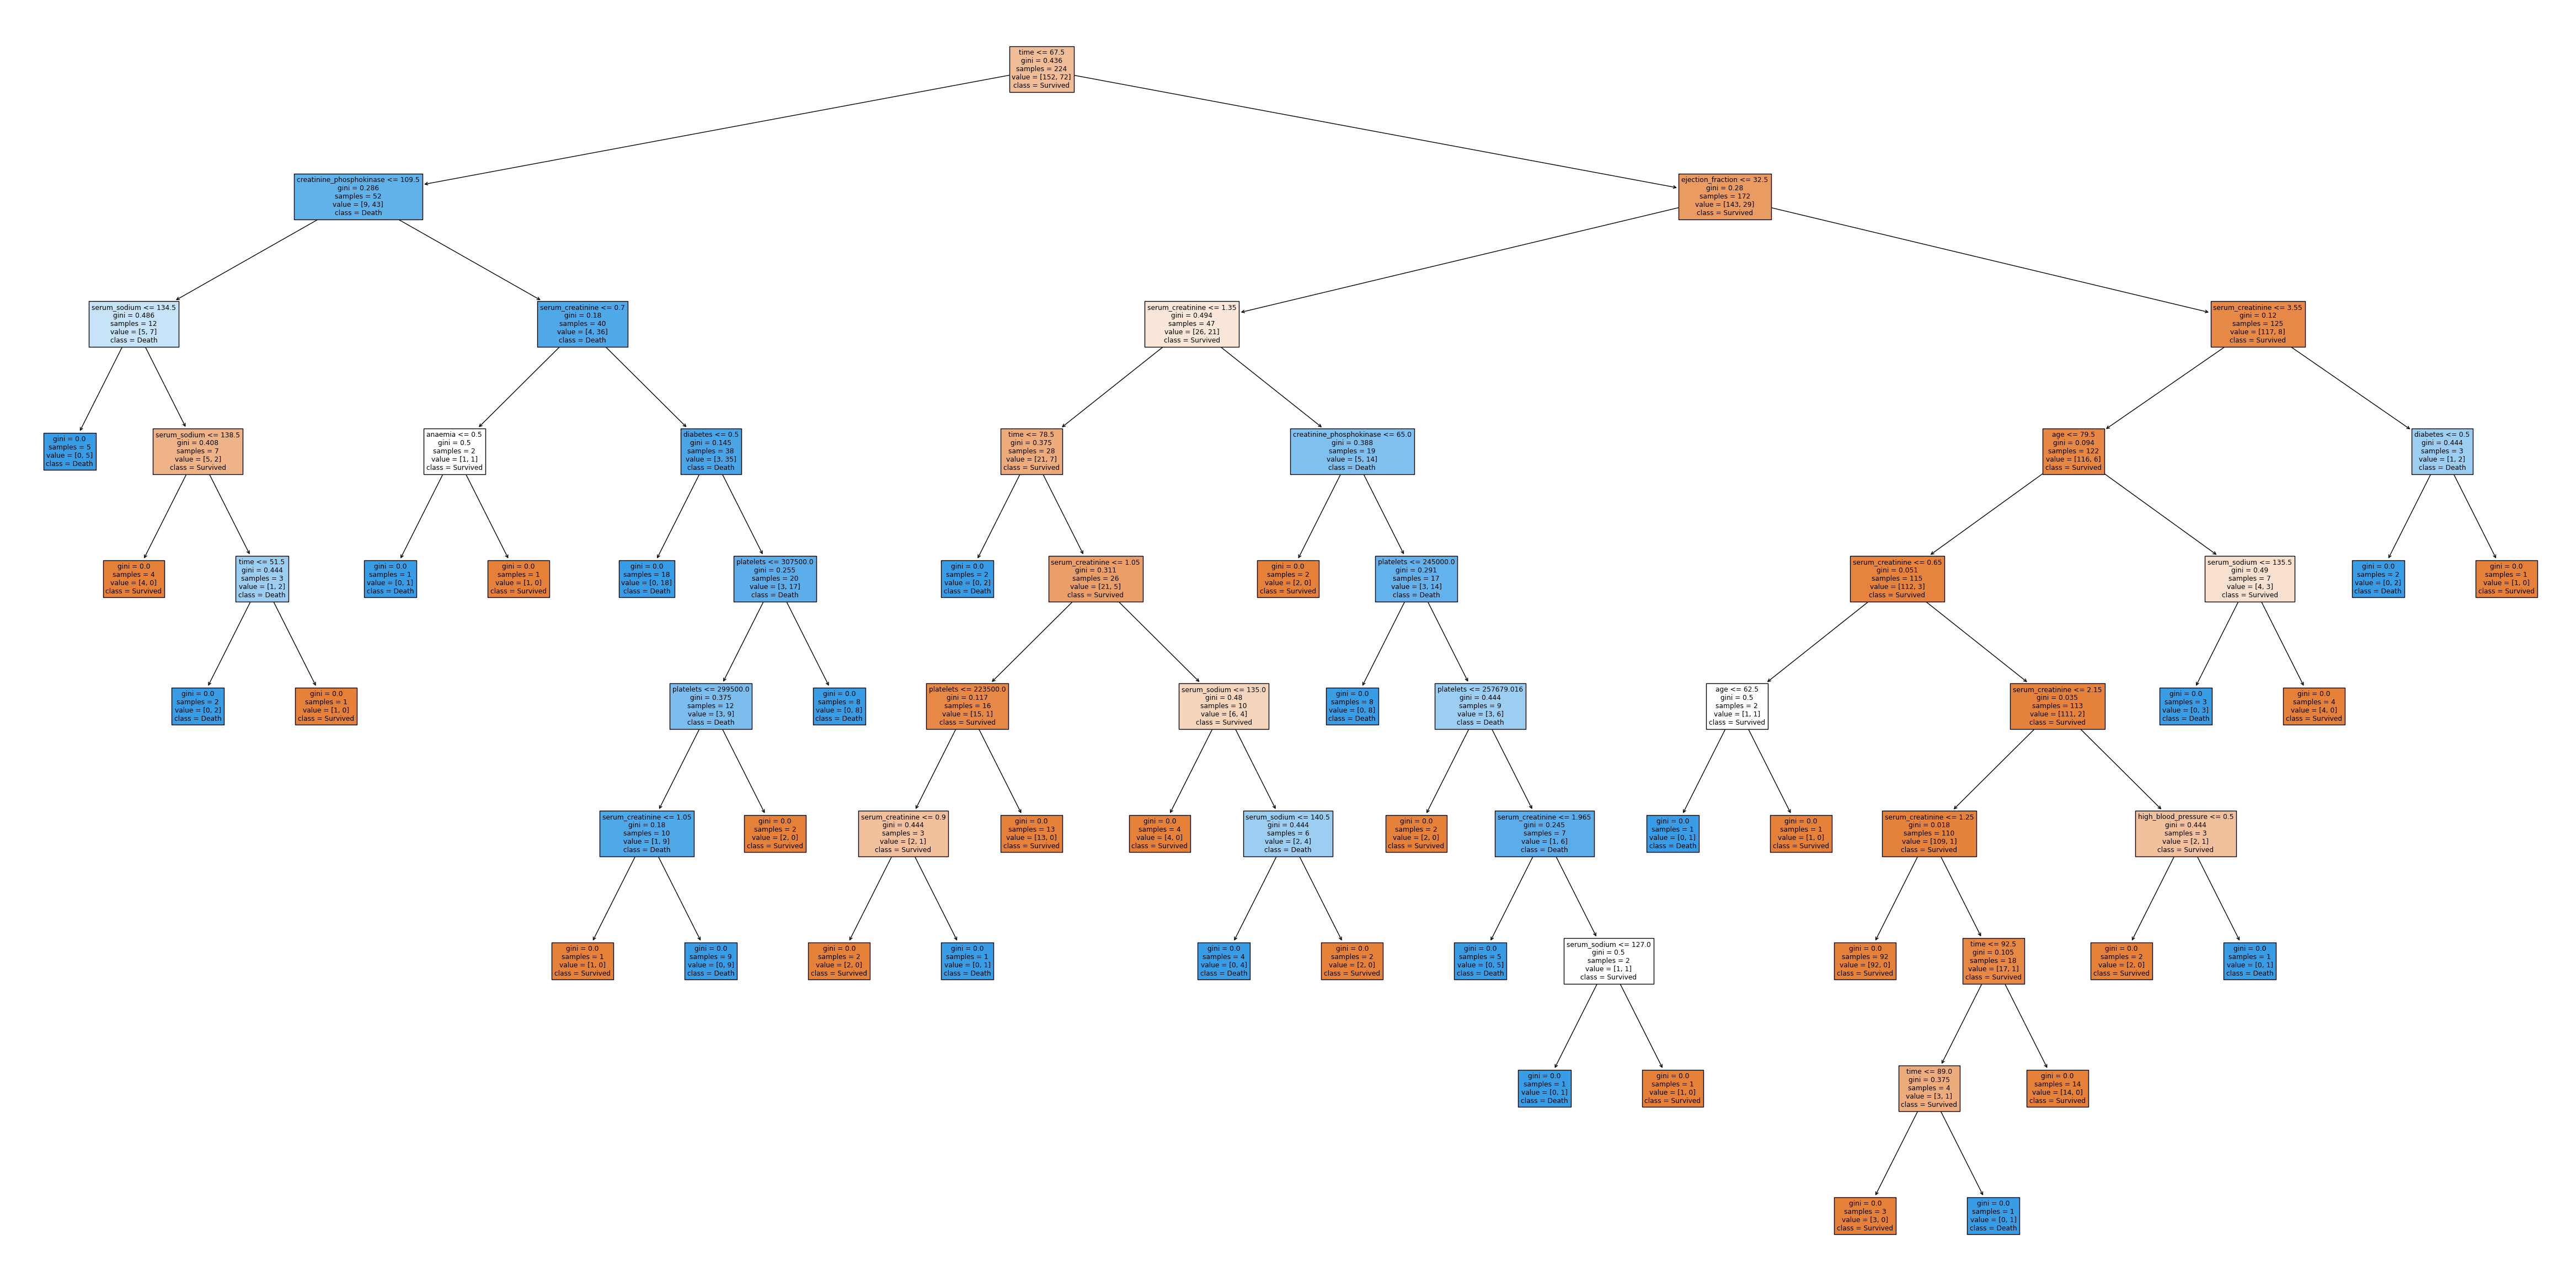

In [31]:
get_dt_graph(tree)

### Hyper-parameter tuning

In [32]:
dt = DecisionTreeClassifier(random_state=42)

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [35]:
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [36]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=42)

              precision    recall  f1-score   support

           0       0.89      0.92      0.90        51
           1       0.82      0.75      0.78        24

    accuracy                           0.87        75
   macro avg       0.85      0.84      0.84        75
weighted avg       0.86      0.87      0.87        75



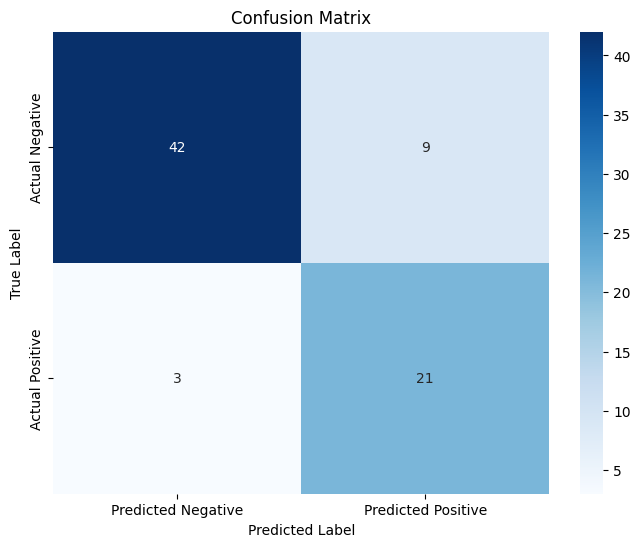

In [41]:
best_tree= grid_search.best_estimator_
print(classification_report(y_test, best_tree.predict(X_test)))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

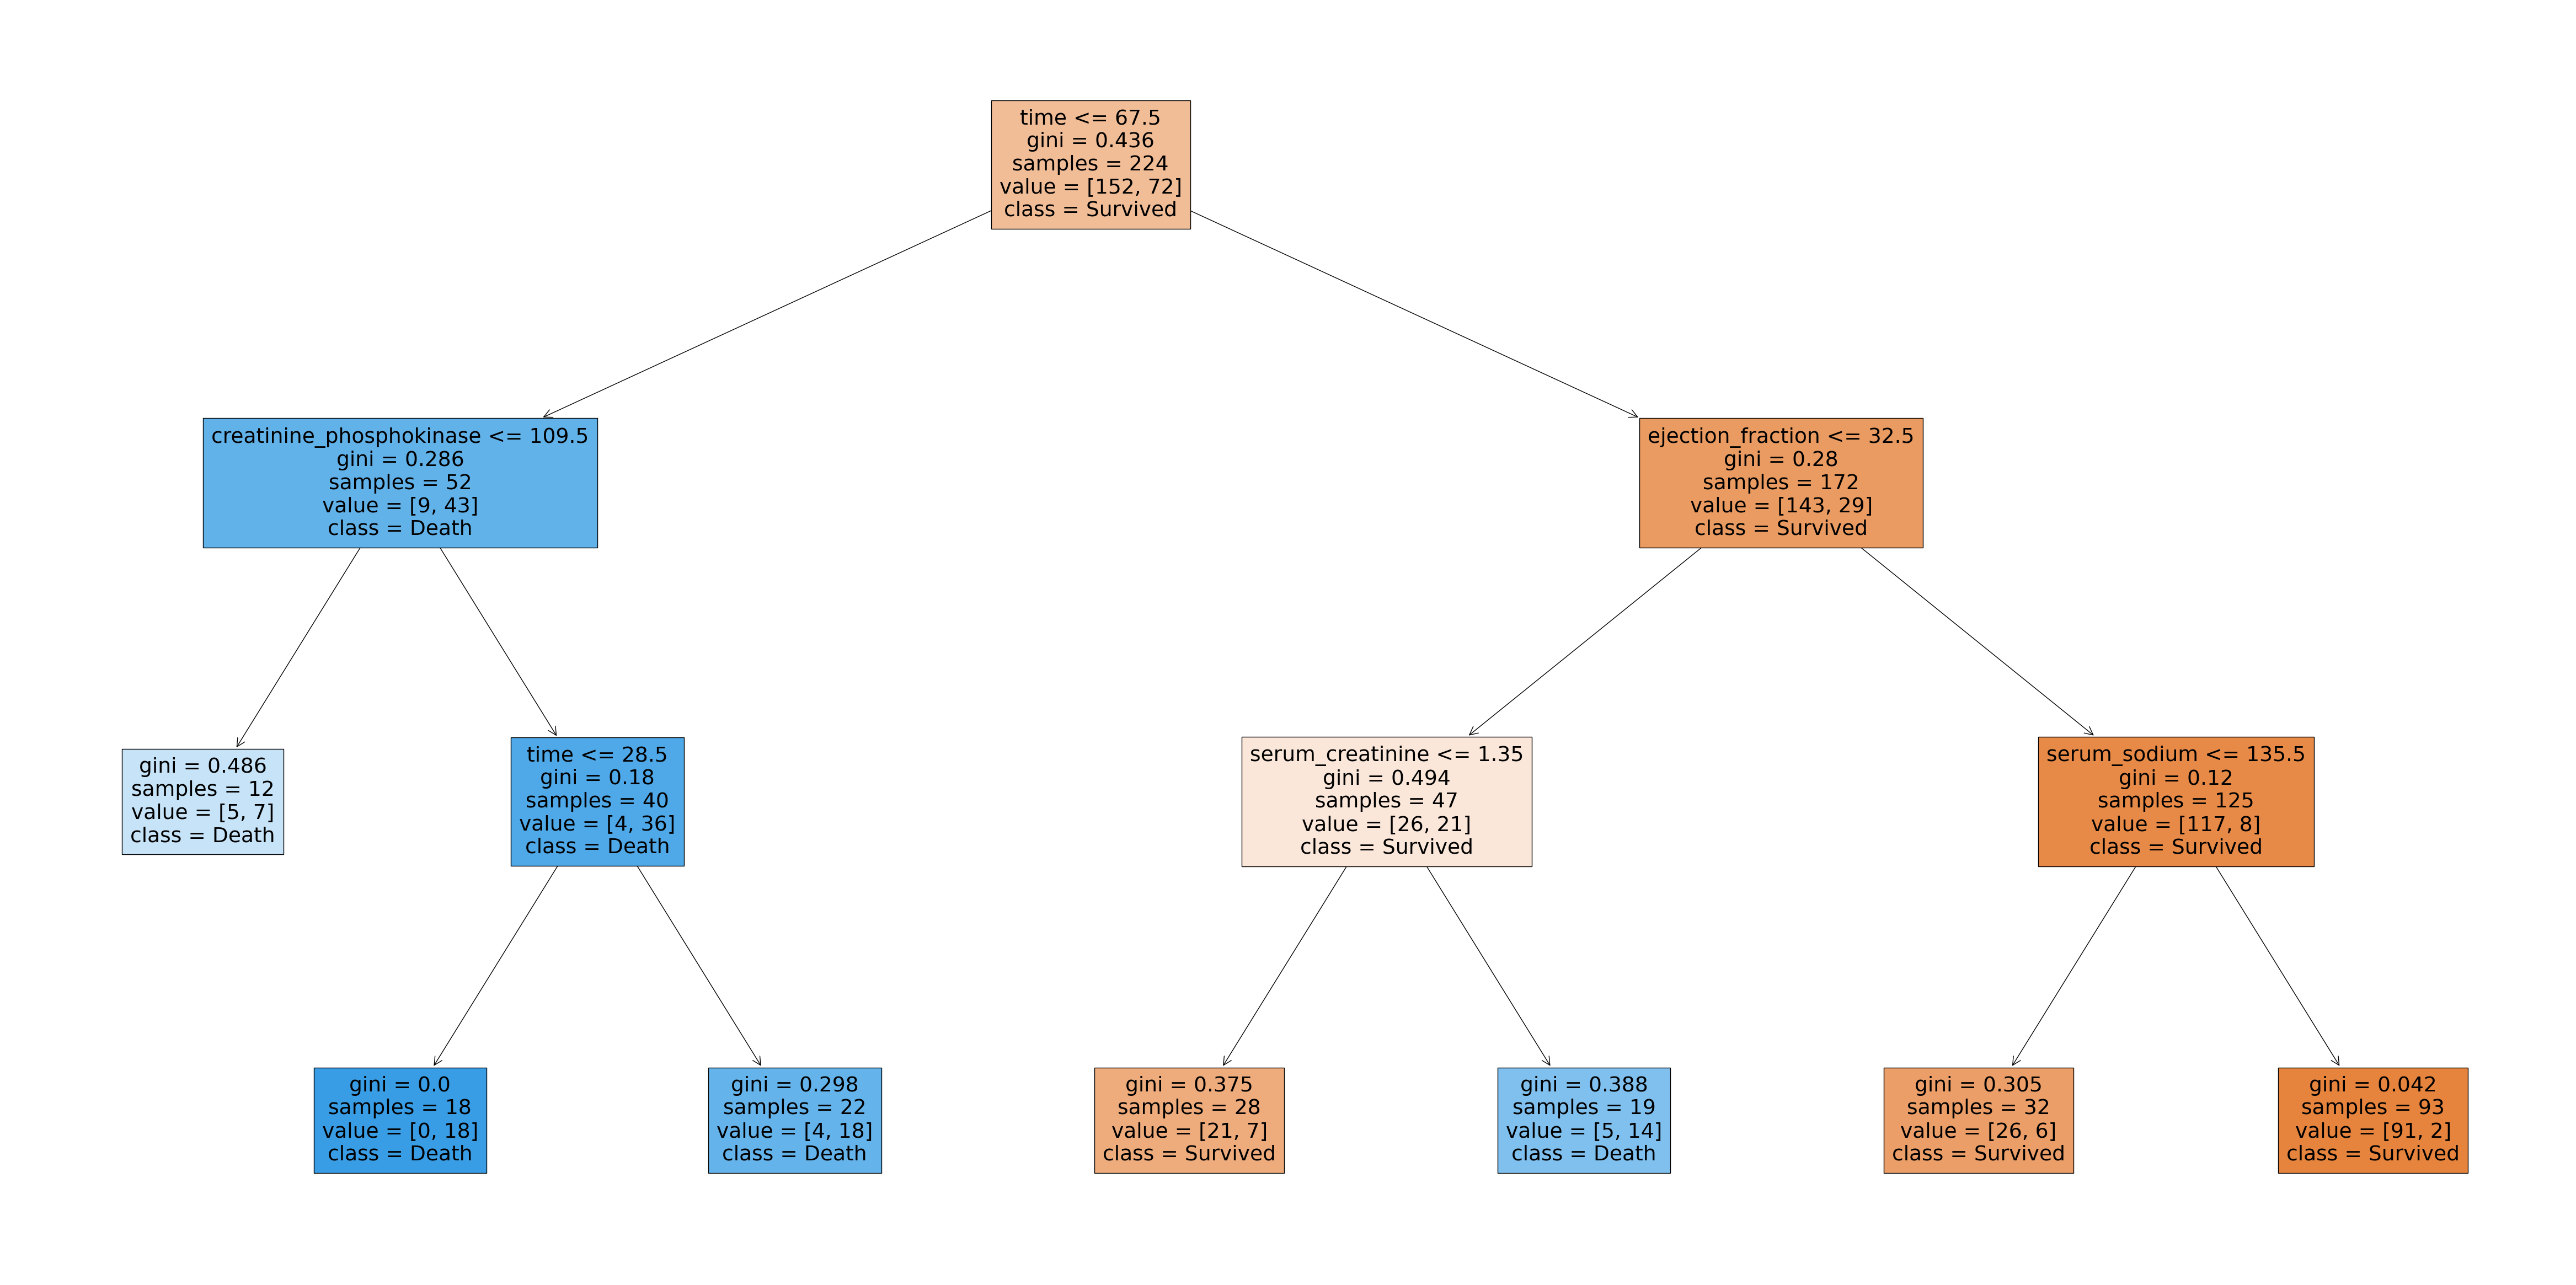

In [42]:
get_dt_graph(best_tree)

In [51]:
import numpy as np
import pandas as pd
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the BaggingClassifier
bagging = BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=100, random_state=42)

# Fit the BaggingClassifier to generate training sets
bagging.fit(X, Y)

# Collect the individual training sets
training_sets = []
for i in range(100):
    # Extract the indices of the samples selected by BaggingClassifier
    indices = bagging.estimators_samples_[i]
    X_train_subset = X.iloc[indices] if isinstance(X, pd.DataFrame) else X[indices]
    y_train_subset = Y.iloc[indices] if isinstance(Y, pd.Series) else Y[indices]
    training_sets.append((X_train_subset, y_train_subset))

# Initialize a list to store the trained Random Forest models
rf_models = []

for X_train_subset, y_train_subset in training_sets:
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_subset, y_train_subset)
    rf_models.append(rf)

# Initialize a list to store the accuracy scores
accuracy_scores = []

# Evaluate each Random Forest model on the testing set
for rf in rf_models:
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Calculate the average error
average_accuracy = np.mean(accuracy_scores)
average_error = 1 - average_accuracy

print(f'Average classification error: {average_error}')




Average classification error: 0.04733333333333323


In [52]:
print(average_accuracy)

0.9526666666666668


# ONLY 1 RANDOM FOREST WITH parameter tuning


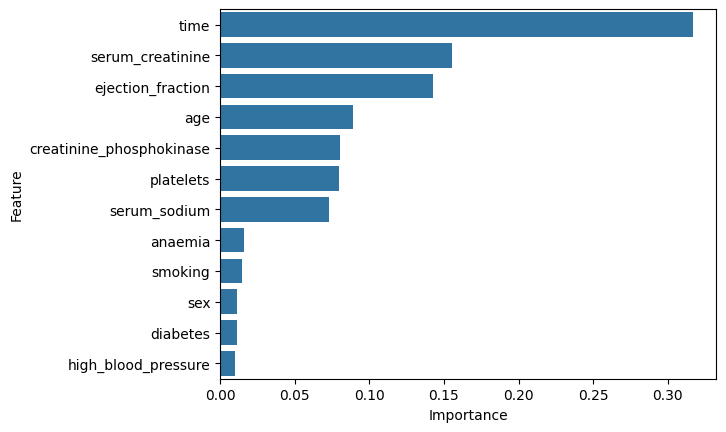

In [58]:
model=RandomForestClassifier(class_weight='balanced', random_state=0)
model.fit(X_train,y_train)
df_feat=pd.DataFrame({'Feature':X.columns,
                      'Importance':model.feature_importances_})
df_feat.sort_values(by='Importance', ascending=False, inplace=True)
df_feat.reset_index(inplace=True)

sns.barplot(x='Importance',y='Feature', data=df_feat, orient='h')
plt.show()

In [77]:
from sklearn.model_selection import GridSearchCV
# param_grid = {
#     "n_estimators": [20,60,100,120], # Number of trees in random forest
#     "max_features": [0.5,1,'auto'], # Number of features to consider at every split
#     "max_depth": [2,8,None], # Maximum number of levels in tree
#     'max_samples':[0.5,0.75,1.0]
# }

# clf = RandomForestClassifier()
# grid = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=2, cv=5)
# grid.fit(X_train, y_train)

n_estimators=[20,60,100,120]
max_features=[0.2,0.6,1.0]
max_depth=[2,8,None]
max_samples=[0.5,0.75,1.0]
param_grid={ 'n_estimators':n_estimators,
            'max_features': max_features,
            'max_depth': max_depth,
            'max_samples': max_samples
    
}
rf_grid=GridSearchCV( estimator=rf,
                     param_grid=param_grid,
                     cv=5,
                     verbose=2,
                     n_jobs=-1
)
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 8, None],
                         'max_features': [0.2, 0.6, 1.0],
                         'max_samples': [0.5, 0.75, 1.0],
                         'n_estimators': [20, 60, 100, 120]},
             verbose=2)

In [78]:
accuracy_score(y_test, rf_grid.predict(X_test))

0.9066666666666666